In [48]:
%matplotlib inline
from __future__ import division

In [49]:
import os
from sklearn.datasets import load_files

In [50]:
train = load_files(os.path.join(os.getcwd(), '..', 'data', 'raw', '20news-bydate', '20news-bydate-train'), encoding = 'utf-8', decode_error= 'replace')
print train.keys()
test = load_files(os.path.join(os.getcwd(), '..', 'data', 'raw', '20news-bydate', '20news-bydate-test'), encoding = 'utf-8', decode_error= 'replace')
print train.keys()

['target_names', 'data', 'target', 'DESCR', 'filenames']
['target_names', 'data', 'target', 'DESCR', 'filenames']


In [51]:
from collections import Counter
import matplotlib.pyplot as plt

<Container object of 20 artists>

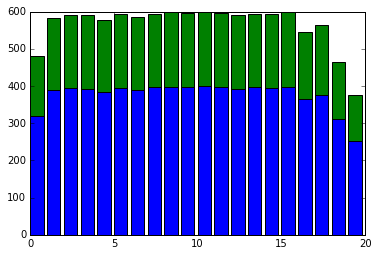

In [52]:
train_distrib = Counter(train['target'])
test_distrib = Counter(test['target'])
plt.bar(train_distrib.keys(), train_distrib.values(), color='g')
plt.bar(test_distrib.keys(), test_distrib.values(), color='b')

In [53]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
import re

In [54]:
def preprocess(text):
    text = text.lower()
    tokenizer = RegexpTokenizer(r'[a-z]+')
    tokens = tokenizer.tokenize(text)
    filtered_words = [w for w in tokens if not w in stopwords]
    stemmed_words = [stemmer.stem(w) for w in filtered_words]
    return " ".join(stemmed_words)

In [55]:
from tqdm import tqdm

In [56]:
for i in tqdm(range(len(train['data']))):
    train['data'][i] = preprocess(train['data'][i])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11314/11314 [00:16<00:00, 690.51it/s]


In [57]:
for i in tqdm(range(len(test['data']))):
    test['data'][i] = preprocess(test['data'][i])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7532/7532 [00:10<00:00, 731.26it/s]


In [58]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [59]:
vect = CountVectorizer()
tfidf = TfidfTransformer()
train_vect = vect.fit_transform(train['data'])
test_vect = vect.transform(test['data'])
train_tfidf = tfidf.fit_transform(train_vect)
test_tfidf = tfidf.transform(test_vect)

In [60]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import f1_score

In [14]:
clf = SVC(kernel='linear', probability= True, verbose = True, decision_function_shape= 'ovr')
%time clf.fit(train_tfidf, train['target'])

[LibSVM]Wall time: 9min 41s


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [15]:
predicted = clf.predict(test_tfidf)

In [16]:
f1_score(test['target'], predicted, average= 'macro')

0.82622209840653338

In [62]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
clf = RandomForestClassifier(n_estimators=10, max_features=None, n_jobs=-1)
clf.fit(train_tfidf, train['target'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [19]:
predicted = clf.predict(test_tfidf)
f1_score(test['target'], predicted, average= 'macro')

0.64630599696986368

In [61]:
from sklearn.grid_search import GridSearchCV

In [21]:
clf = RandomForestClassifier(max_features=None, n_jobs=-1)
param_grid = {
    "n_estimators": range(10, 210, 10)
}
grid_search = GridSearchCV(clf, param_grid=param_grid, verbose=1000)
grid_search.fit(train_tfidf, train['target'])
grid_search.grid_scores_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] n_estimators=10 .................................................
[CV] ........................ n_estimators=10, score=0.724503 -  17.9s
[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:   17.9s
[CV] n_estimators=10 .................................................
[CV] ........................ n_estimators=10, score=0.714021 -  18.4s
[Parallel(n_jobs=1)]: Done   2 tasks       | elapsed:   36.4s
[CV] n_estimators=10 .................................................
[CV] ........................ n_estimators=10, score=0.715879 -  18.3s
[Parallel(n_jobs=1)]: Done   3 tasks       | elapsed:   54.8s
[CV] n_estimators=20 .................................................
[CV] ........................ n_estimators=20, score=0.730596 -  30.8s
[Parallel(n_jobs=1)]: Done   4 tasks       | elapsed:  1.4min
[CV] n_estimators=20 .................................................
[CV] ........................ n_estimators=20, score

KeyboardInterrupt: 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [32:59<00:00, 23.22s/it]


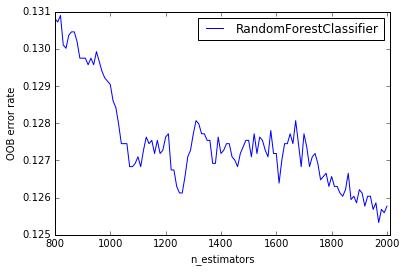

In [28]:
from collections import OrderedDict
ensemble_clfs = [
    ("RandomForestClassifier",
        RandomForestClassifier(warm_start=True, oob_score=True, n_jobs=-1))
]
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)
min_estimators = 800
max_estimators = 2010
for label, clf in ensemble_clfs:
    for i in tqdm(range(min_estimators, max_estimators, 10)):
        clf.set_params(n_estimators=i)
        clf.fit(train_tfidf, train['target'])

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [12:52<00:00, 37.96s/it]


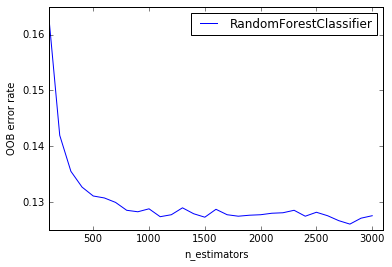

In [20]:
from collections import OrderedDict
ensemble_clfs = [
    ("RandomForestClassifier",
        RandomForestClassifier(warm_start=True, oob_score=True, n_jobs=-1))
]
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)
min_estimators = 100
max_estimators = 3100
for label, clf in ensemble_clfs:
    for i in tqdm(range(min_estimators, max_estimators, 100)):
        clf.set_params(n_estimators=i)
        clf.fit(train_tfidf, train['target'])

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [30]:
clf = RandomForestClassifier(n_estimators=1500, n_jobs=-1)
clf.fit(train_tfidf, train['target'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [31]:
predicted = clf.predict(test_tfidf)
f1_score(test['target'], predicted, average= 'macro')

0.77909912904272272

In [32]:
clf = RandomForestClassifier(n_estimators=2000, n_jobs=-1)
clf.fit(train_tfidf, train['target'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [33]:
predicted = clf.predict(test_tfidf)
f1_score(test['target'], predicted, average= 'macro')

0.78109089700295997

In [127]:
import gc
gc.collect()

79

In [13]:
U_x = train_tfidf[:].toarray()
U_y = train['target'][:]
L_x = []
L_y = []
test_data = test_tfidf[:].toarray()
test_target = test['target'][:]

In [63]:
print train_tfidf.shape
print len(train['target'])

(11314, 69637)
11314


In [64]:
idxs = np.random.randint(len(train['target']), size=100)
L_tfidf = train_tfidf.getrow(idxs[0])
print L_tfidf.shape
for idx in tqdm(range(1, len(idxs))):
    row = train_tfidf.getrow(idx)
    L_tfidf = scipy.sparse.vstack((L_tfidf, row))
idxs = list(idxs)
mask = np.ones(train_tfidf.shape[0], bool)
mask[idxs] = False
train_tfidf = train_tfidf[mask]
L_target = []
L_target = np.append(L_target, np.take(train['target'], idxs))
train['target'] = np.delete(train['target'], idxs)

(1, 69637)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 7615.38it/s]


In [65]:
print train_tfidf.shape
print len(train['target'])

(11215, 69637)
11215


In [66]:
print L_tfidf.shape
print len(L_target)

(100, 69637)
100


In [67]:
import numpy as np
import random
import scipy

In [68]:
clf = RandomForestClassifier(n_estimators=1500, n_jobs=-1)
clf.fit(L_tfidf, L_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [70]:
predicted = clf.predict(test_tfidf)
f1_score(test['target'], predicted, average= 'macro')

C:\Users\vladimir\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.027080399119834991

In [73]:
labels = Counter(L_target)
print labels
labels_sum = sum(labels.values())
print labels_sum
for label in labels.keys():
    labels[label] = labels[label] / labels_sum
print labels

Counter({2.0: 8, 13.0: 8, 7.0: 7, 8.0: 7, 9.0: 7, 18.0: 6, 0.0: 5, 1.0: 5, 10.0: 5, 14.0: 5, 16.0: 5, 19.0: 5, 3.0: 4, 4.0: 4, 5.0: 4, 11.0: 4, 12.0: 4, 6.0: 3, 17.0: 3, 15.0: 1})
100
Counter({2.0: 0.08, 13.0: 0.08, 7.0: 0.07, 8.0: 0.07, 9.0: 0.07, 18.0: 0.06, 0.0: 0.05, 1.0: 0.05, 10.0: 0.05, 14.0: 0.05, 16.0: 0.05, 19.0: 0.05, 3.0: 0.04, 4.0: 0.04, 5.0: 0.04, 11.0: 0.04, 12.0: 0.04, 6.0: 0.03, 17.0: 0.03, 15.0: 0.01})


In [77]:
sd_samples = []
probs = clf.predict_proba(train_tfidf)
probs.shape

(11215L, 20L)

In [85]:
#count pic for each instance
#стандартные девиации
sds = []
for sample in tqdm(probs):
    arr = []
    denom = 0
    for classid, prob in enumerate(sample):
        denom += prob / labels[classid]
    for classid, prob in enumerate(sample):
        arr = np.append(arr, (prob / labels[classid]) / denom)
    sds = np.append(sds, np.std(arr))
print len(sds)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11215/11215 [00:01<00:00, 6817.63it/s]


11215
